# Object masks from prompts with SAM

SAM model obyekt maska predict qiladi berilgan promptlar (prompt bu berilgan nuqta bolishi mumkun) yordamida. Model birinchi rasmni embeddingsga convert qiladi sababi berilgan promptdan high quality mask olish uchun. 

The SamPredictor class modelga prompt berish uchun oson interface hisoblanadi. U userga birinchi rasmni **set_image** method orqali  set qilib olish imkonini beradi qaysiki rasm embeddingslarni hisoblab olish uchun. 

Keyin **predict** methodi yordamida berilgan prompt orqali efficiently mask predict qilamiz. 

Model input sifatida ***1)point 2)bbox va 3) previous iterationdagi mask*** ni olishi mumkun

In [1]:
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Necessary functions for SAM predicting


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Example of image

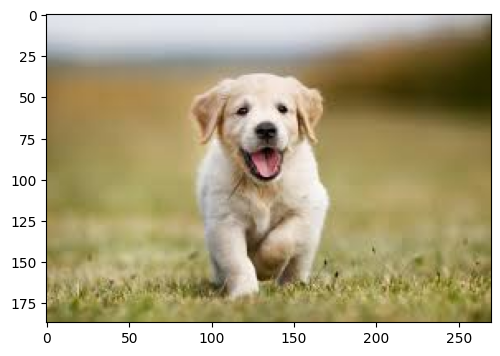

In [3]:
image = cv2.imread("data/puppy.jpg") #
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
plt.imshow(image)
plt.axis('on')
plt.show()

# Selecting objects with SAM


Birinchi bolib, SAM classlar va checkpoint modelini yuklang. sam_model_registry[["model_name"]](checkpoint="model_path") jonatiladi. 
Eng yaxshi natijalarga erishish uchun CUDA da ishlash va standart modeldan foydalanish tavsiya etiladi.

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="checkpoints/sam_vit_b_01ec64.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
sam.to(device)
predictor = SamPredictor(sam)
predictor

In [5]:
#Image ga  set_image orqali  embeddingslar yaratiladi. SamPredictor classi (yoki olingan obyekt) bu olingan embeddingslarni 
#eslab qoladi va keyingi rasm uchun mask predict qilayotganda ishlatadi.
predictor.set_image(image)

Dogni tanlash uchun, dogga tegishli biror nuqtani belgilaymiz. Bu nuqta (x,y) kordinata nuqtai bolib modelga input bolib kiradi. Va 1 label bilan kiradi(1-for foreground) yoki 0 (0-for background). Bir nechta pointlar ham kirgizsak boladi.

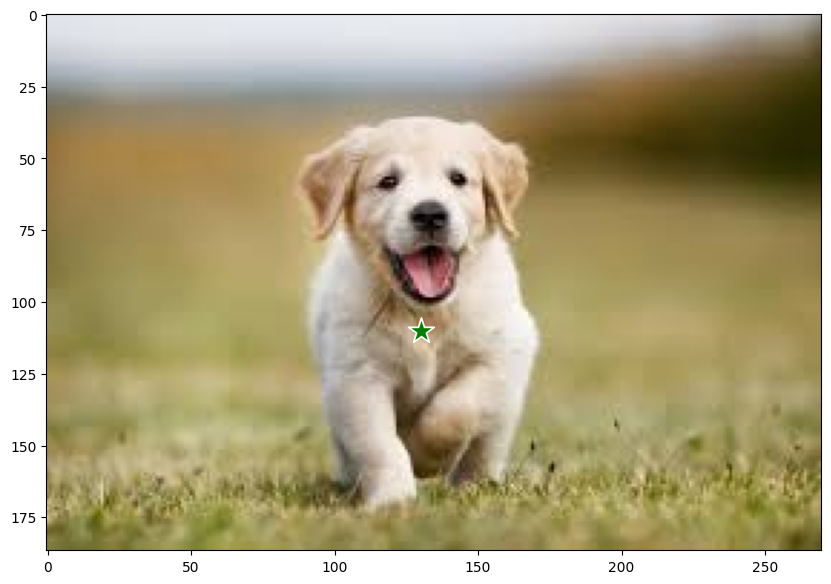

In [6]:
input_point = np.array([[130, 110]]) #dog joylashgan obyektdan biror nuqtani tanladim 
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

**SamPredictor.predict** classdan olingan obyekt bilan predict qilinadi. The model **masks, scores, logits** lar ni qaytaradi. Ya'ni **mask, quality prediction** (o'sha mask uchun), **low resolution mask logitlar** (qaysiki keyingi iteratrsiyada predict qilish uchun uzatiladi.) 

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)

**multimask_output=True** (the default setting) SAM 3 ta output mask qaytaradi. **scores** modelni yaratgan maskiga nisbatan bergan o'zining quality si boladi. Bu settings asosan ambiguous input prompts (noaniq input promptlarga nisbatan beriladi) va modelga sorovga mos obyetklarni aniqlashga mask berishga yordam beradi. 

**multimask_output=False** bo'lsa u faqatgina bitta single mask qaytaradi. Agar bitta mask istalgan taqdirda ham **multimask_output=True** tavsiya qilinadi. Chunki ularni ichidan **score** eng balandini olib ishlatish maqsadga muvofiqdir. Bu odatda eng yaxshi yaratilgan mask bo'ladi.  

In [8]:
print(masks) #True False - mask mavjud nuqtalarni True qaytaradi
print(masks.shape) # (number_of_masks) x H x W
print(scores)
print(logits.shape)


[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(3, 187, 270)
[0.8534506 0.9066394 0.5061371]
(3, 256, 256)


## Draw a mask

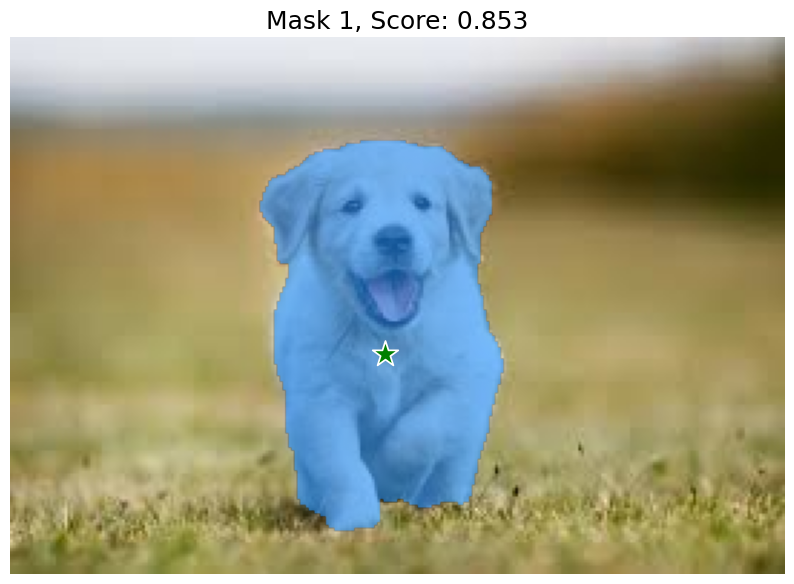

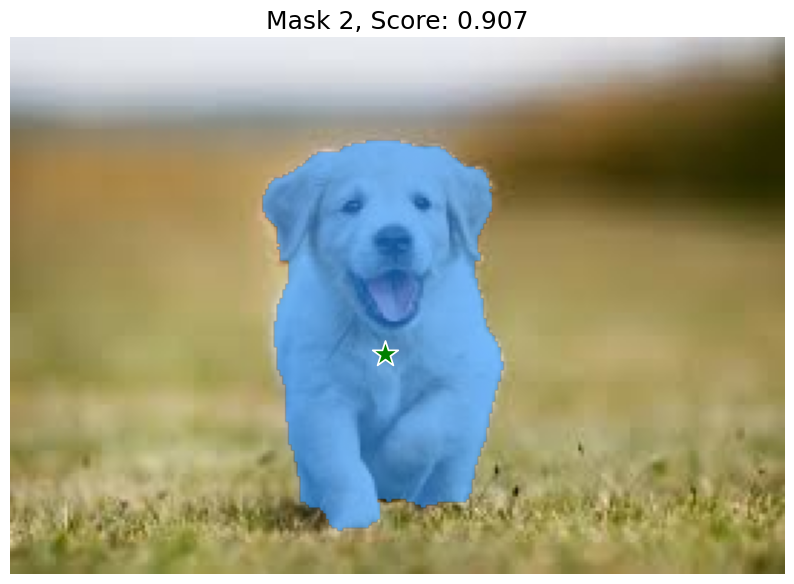

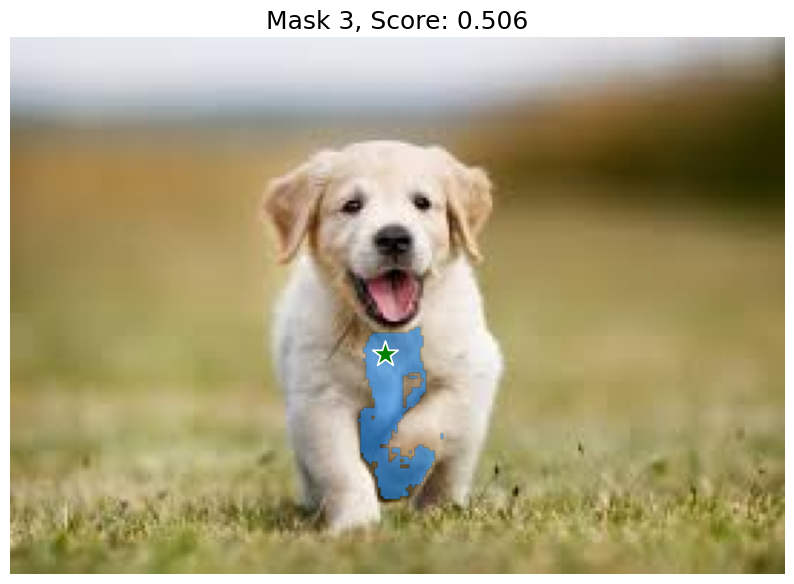

In [9]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  


# Specifying a specific object with additional points

Baribir single point bu ambigious (noaniq), model bir nechta masklar qaytarishi mumkun unga munosib tarzda. Bu noqulaylkdan qochish va single obyektni segment qilish uchun **multiple points** ishlatsak bo'ladi. Agar mavjud bo'lsa, bashorat qilishda yordam berish uchun modelga oldingi iteratsiyadan mask ham berilishi mumkin. Multiple promptlar bilan single obyekt segment qilinayotganda **multimask_output=False** bolishi lozim 

In [10]:
input_point = np.array([[130, 110], [130, 50]])
input_label = np.array([1, 1])
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [11]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

(187, 270)


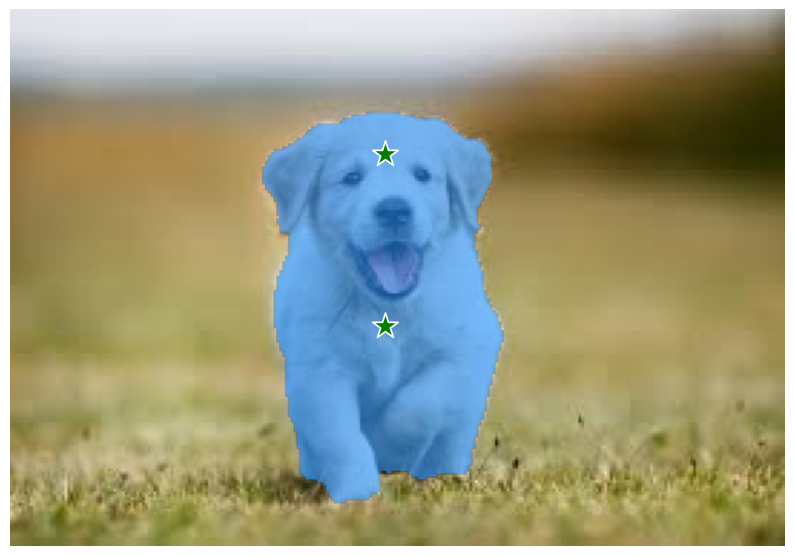

In [12]:
print(mask.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## BItta obyektdagi ma'lum bir qismni segment qilish 
buning uchun input labelni biriga 0 beramiz 

In [13]:
input_point = np.array([[130, 50], [200, 100]])
input_label = np.array([0, 1]) #0 bu backgroudn uchun . 
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [14]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

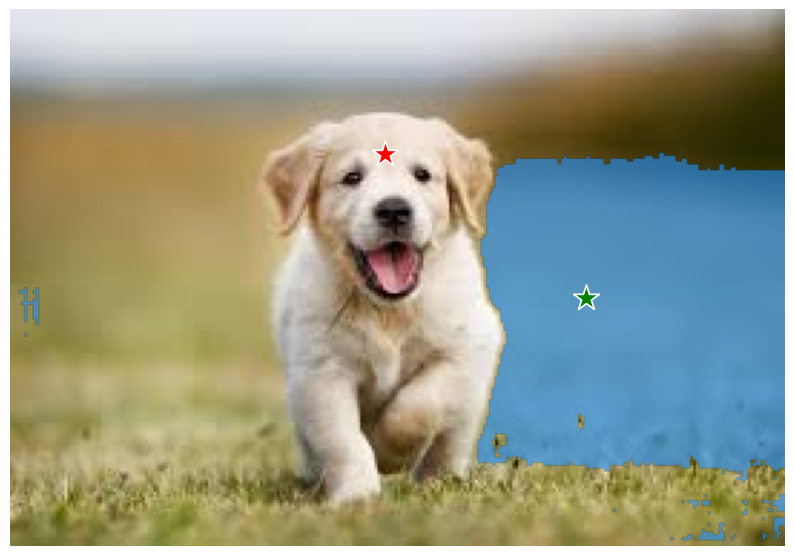

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## BBOX orqali segment qilish

The model can also take a box as input, provided in xyxy format.

In [16]:
input_box = np.array([80, 25, 180, 175])

In [17]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

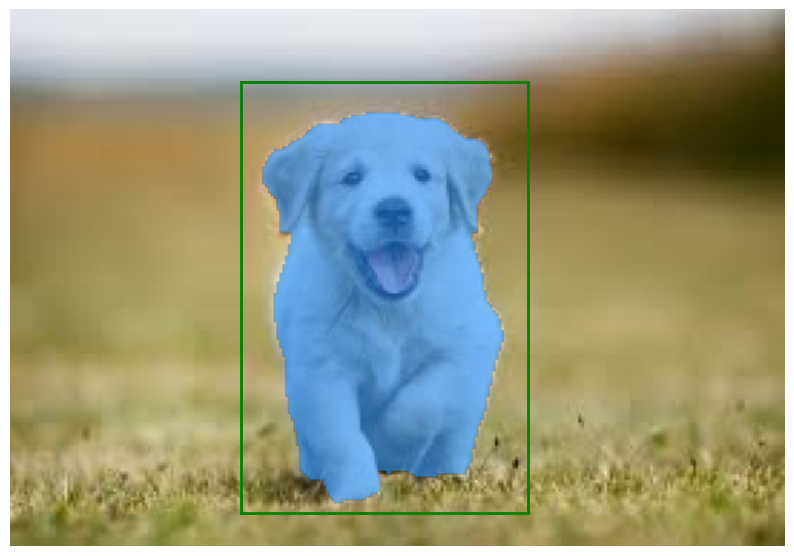

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes Bbox va point orqali segment qilish

In [19]:
input_box = np.array([80, 25, 180, 175])
input_point = np.array([[130, 110]])
input_label = np.array([1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

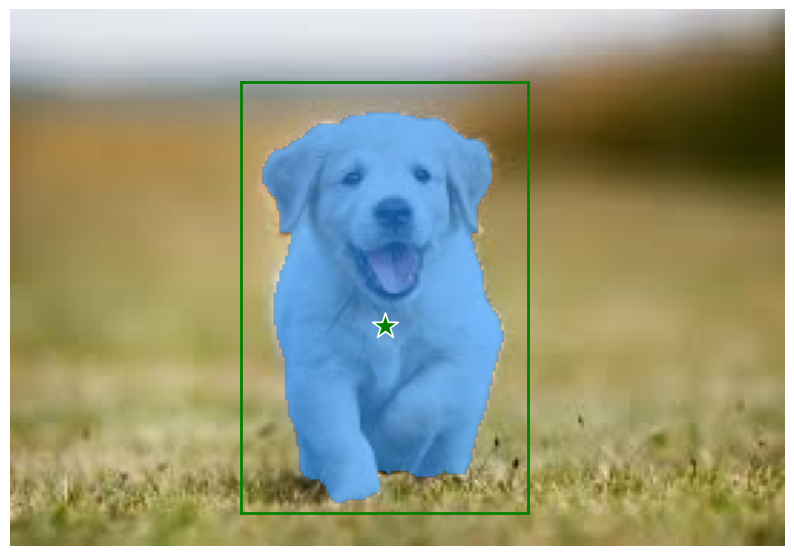

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# Torch Batch Promt berish

SamPredictor can take multiple input prompts for the same image, using predict_torch method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

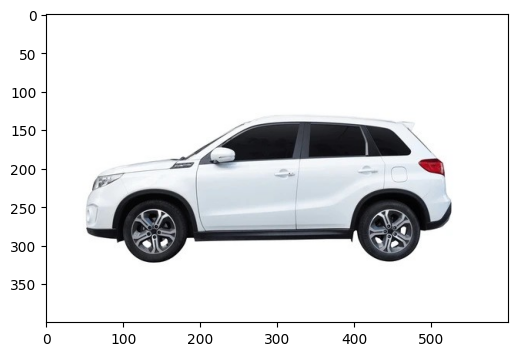

In [28]:
img = cv2.imread("data/car.jpg") #
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
plt.imshow(img)
plt.axis('on')
plt.show()

In [29]:
input_boxes = torch.tensor([
    [20, 120, 550, 350],
    [100, 220, 200, 330],
    [400, 220, 490, 330],
], device=predictor.device)

Boxlarni input frame torchga ga convert qiladi va keyin maskani predict qiladi. **SamPredictor** classida **transform** methodi mavjud bu method orqali osongina dataloader yasab olish mumkun (segment_anything.utils.transforms)


In [35]:
predictor.set_image(img)

In [36]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img.shape[:2]) #[:2] image faqat H va W ni oladi
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [37]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([3, 1, 400, 600])

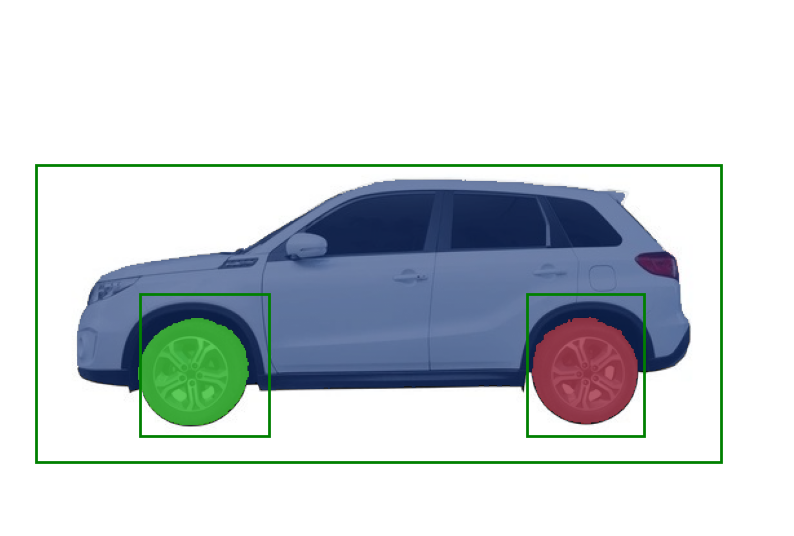

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference
If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:

image: The input image as a PyTorch tensor in CHW format.
original_size: The size of the image before transforming for input to SAM, in (H, W) format.
point_coords: Batched coordinates of point prompts.
point_labels: Batched labels of point prompts.
boxes: Batched input boxes.
mask_inputs: Batched input masks.
If a prompt is not present, the key can be excluded.

In [39]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [40]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

NameError: name 'image1' is not defined

In [41]:
batched_output = sam(batched_input, multimask_output=False)

NameError: name 'batched_input' is not defined

The output is a list over results for each input image, where list elements are dictionaries with the following keys:

masks: A batched torch tensor of predicted binary masks, the size of the original image.
iou_predictions: The model's prediction of the quality for each mask.
low_res_logits: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.